In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import utils

plt.rcParams['figure.figsize'] = [8, 6]
sns.set_theme(style="ticks", color_codes=True)
df = pd.read_csv('volby.csv', low_memory=False)
df = utils.rename_cols(df)

# Elections dataset report
## Initial information
### Objective
Estimate voter turnout per town, see whether it will be above/below region average.

### Data
Contains information about voter attendance per town in the 2013 and 2017 elections. Contains votes per party and demographic data for each voting district.

Demographic data will be worthwhile to investigate, to see whether it correlates to voter turnout. Votes per party may also be a factor. Explore if voters of certain parties are more likely to attend and therefore towns leaning towards those parties are more likely to have higher attendance.

### Goal
Estimate voter attendance per town and figure out per-region estimate.

## Data exploration
### Data format
The data is in csv format containing absolute and percentage values for the demographic and party entries. While the percentage data could be considered redundant (due to the absolutes values being present) those are the numbers that will be used during the analysis.

Initially, the data were saved in an unusual encoding that made the czech regional character unreadable when opened using any of the standard encodings. For that reason, I had to perform manual cleaning of the table headers.

### Voter count and voter attendance
The country seems to be split up into voting districts that are mostly up to 1000 voters. Using the attendance data, we will explore other data points and evaluate the correlation. Afterwards, a model will be created using the data and voter attendance will be predicted for each voting district.

In [2]:
attendances = ['attendance_13', 'attendance_17']
educ_levels_cols = [
    'Vzd_zakl_A', 'Vzd_str_be_A', 'Vzd_str_sm_A',
    'Vzd_nast_A', 'Vzd_vos_A', 'Vzd_vysok_A'
]
empl_states_cols = [
    'Eko_zam_A', 'Eko_post_p_A',
    'Eko_nezam_A', 'Nepracduch_A',
]
misc_cols =  [
    'Muzi_A', 'Zeny_A', 'Rodst_rozv_A',
    'Nar_romska_A', 'Nab_rimsko_A',
]
age_cols = ['Sum_v0_14_A', 'V65avic_A']
demographics_cols = educ_levels_cols + empl_states_cols + age_cols + misc_cols

In [3]:
desc = df.describe().swapaxes(0, 1)
items = df.shape[0]
desc[desc['count']< items]

,count,mean,std,min,25%,50%,75%,max
Obec_okrsek_final2016,13660.0,1.629125e+07,2.058844e+07,5.000111e+06,5.492582e+06,5.709312e+06,5.969736e+06,5.998081e+07
PAR_2017_1_ODS,14745.0,3.871278e+01,3.624411e+01,0.000000e+00,1.000000e+01,2.900000e+01,5.700000e+01,4.310000e+02
PAR_2017_2,14745.0,5.911835e-01,1.254770e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,2.900000e+01
PAR_2017_3,14745.0,2.544591e-01,6.260785e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.000000e+00
PAR_2017_4_CSSD,14745.0,2.493204e+01,1.874933e+01,0.000000e+00,9.000000e+00,2.200000e+01,3.700000e+01,2.250000e+02
...,...,...,...,...,...,...,...,...
Nab_rimsko_A,14759.0,1.157348e+01,1.016100e+01,0.000000e+00,4.672897e+00,8.344924e+00,1.491525e+01,7.837838e+01
Eko_zam_A,14759.0,4.300815e+01,5.753903e+00,0.000000e+00,3.989899e+01,4.334239e+01,4.650192e+01,6.261607e+01
Eko_post_p_A,14759.0,5.896289e+00,2.248385e+00,0.000000e+00,4.357980e+00,5.649718e+00,7.174640e+00,2.631579e+01
Eko_nezam_A,14759.0,4.852644e+00,2.236066e+00,0.000000e+00,3.415779e+00,4.485981e+00,5.882353e+00,3.617907e+01


In [4]:
cols_to_delete = [  # These cols hold no information
    'PAR_2017_CHYBA',
    'PAR_2017_OPRAVA',
    'CHYBA_KRAJ16',
    'PAR_2017_TYP_FORM',
    'Poc_budov'
]
df = df.drop(columns=cols_to_delete)

###Missing values
The dataset contains 14745 rows. Ignoring the columns that have been dropped, there are the following issues:

The following 5 rows appear largely incomplete and useless. Due to their low number, they can be safely dropped.

In [5]:
df[df['Muzi'].isna()]

,ID_N,OBEC,Nazev_obce,Okres_nazev,Kraj_nazev,Obec_okrsek_final2016,OBEC_Okrsek,PAR_2017_1_ODS,PAR_2017_2,PAR_2017_3,...,Vzd_vos_A,Vzd_nast_A,Vzd_str_sm_A,Vzd_str_be_A,Vzd_zakl_A,Nab_rimsko_A,Eko_zam_A,Eko_post_p_A,Eko_nezam_A,Nepracduch_A
1773,1774,539911,Příbram,Příbram,Středočeský kraj,53991139.0,539911_39,62.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2101,2102,536032,Strýčice,České Budějovice,Jihočeský kraj,5360321.0,536032_1,2.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3234,3235,553085,Skopytce,Tábor,Jihočeský kraj,5530852.0,553085_2,5.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12384,12427,597180,Bruntál,Bruntál,Moravskoslezský kraj,59718019.0,597180_19,1.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14219,14288,500208,Praha 8,Praha,Praha,NaN,500208_8091,146.0,2.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df = df.drop(index=df[df['Muzi'].isna()].index)

In [7]:
na_df = df[df['ODEVZ_OBAL_KRAJ16'].isna()]
na_df[na_df.columns[na_df.isna().any()]]

,Obec_okrsek_final2016,PAR_2017_ID_OKRSKY,PAR_2017_OKRES,PAR_2017_OKRSEK,reg_voters_17,PAR_2017_VYD_OBALKY,votes_17,PAR_2017_PL_HL_CELK,VOL_SEZNAM_KRAJ16,VYD_OBALKY_KRAJ16,...,PAR_2013_20_ANO,PAR_2013_21_KSCM,PAR_2013_22,PAR_2013_23_SZ,PAR_2013_24,reg_voters_13,PrumerrzVYDOB,PrumerzODOB,votes_13,Ztracene_obalky
13634,5546694.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13660,NaN,837.0,1100.0,1001.0,682.0,537.0,537.0,537.0,NaN,NaN,...,75.0,28.0,0.0,70.0,3.0,1004.0,798.0,790.0,785.0,8.0
13661,NaN,838.0,1100.0,1002.0,1226.0,941.0,934.0,931.0,NaN,NaN,...,79.0,35.0,0.0,78.0,2.0,1161.0,806.0,805.0,800.0,1.0
13662,NaN,839.0,1100.0,1003.0,670.0,511.0,511.0,498.0,NaN,NaN,...,49.0,22.0,1.0,33.0,0.0,682.0,477.0,475.0,474.0,2.0
13663,NaN,840.0,1100.0,1004.0,815.0,597.0,597.0,596.0,NaN,NaN,...,49.0,22.0,0.0,55.0,1.0,847.0,573.0,571.0,569.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14759,NaN,1774.0,1100.0,18008.0,975.0,606.0,606.0,600.0,NaN,NaN,...,121.0,56.0,1.0,22.0,2.0,980.0,620.0,620.0,620.0,0.0
14760,NaN,1775.0,1100.0,18009.0,1069.0,691.0,691.0,690.0,NaN,NaN,...,120.0,70.0,1.0,26.0,2.0,974.0,619.0,619.0,615.0,0.0
14761,NaN,1776.0,1100.0,18010.0,976.0,628.0,628.0,625.0,NaN,NaN,...,161.0,58.0,0.0,44.0,0.0,1617.0,857.0,857.0,849.0,0.0
14762,NaN,1777.0,1100.0,18011.0,1037.0,692.0,692.0,686.0,NaN,NaN,...,141.0,70.0,1.0,24.0,0.0,932.0,597.0,596.0,593.0,1.0


There are 1103 rows with missing data about the 2016 elections. This is not an insignificant number. Should the 2016 elections data be considered for the model, it would may be wise to correct these rows. If that isn't the case, the columns may be dropped.

Upon further investigation, the 2016 regional elections were not held in Prague, which is why the data is missing. Given the specific location for the missing data, the capital city, tends to behave differently during elections from the rest of the country, it might make using the 2016 election data more difficult and a separate model for the capital may be required, should this election be considered

In [8]:
df[df['ODEVZ_OBAL_KRAJ16'].isna()]['Nazev_obce'].value_counts()

Praha 4                                  131
Praha 10                                 109
Praha 8                                  107
Praha 6                                  104
Praha 5                                   81
Praha 11                                  62
Praha 3                                   51
Praha 13                                  51
Praha 12                                  50
Praha 2                                   45
Praha 9                                   41
Praha 7                                   36
Praha 14                                  32
Praha 15                                  23
Praha 1                                   20
Praha 17                                  18
Praha 18                                  12
Praha 20                                  12
Praha-Zbraslav                            10
Praha 16                                   8
Praha 22                                   8
Praha 21                                   8
Praha-Libu

In [9]:
na_df = df[df['reg_voters_17'].isna()]
na_df[['Kraj_nazev']].value_counts()

Kraj_nazev            
Moravskoslezský kraj      371
Jihomoravský kraj         351
Plzeňský kraj             184
Ústecký kraj               97
Pardubický kraj            92
Liberecký kraj             87
Karlovarský kraj            2
Jihočeský kraj              1
Královéhradecký kraj        1
Olomoucký kraj              1
dtype: int64

In [10]:
df = df.dropna(subset=['PAR_2017_1_ODS'])
df[df['reg_voters_17'].isna()].shape[0]

1168

There  1168 rows that are missing information about the 2017 election. There doesn't appear to be an obvious common charactersitic, like with the regional election results. Also, the columns that are missing values from this subset seems to vary quite wildly. These rows, or perhaps a part of them may be salvaged with some effort, but for now, drop them.

In [11]:
df = df.dropna(subset=['reg_voters_17', 'votes_17', 'reg_voters_13', 'votes_13'])
df = utils.make_attendance(df)

In [12]:
voters_attendance = utils.init_row_df(['reg_voters', 'attendance'], 'year')
voters_attendance = utils.add_to_row_df(voters_attendance, df[['reg_voters_17', 'attendance_17']], 2017)
voters_attendance = utils.add_to_row_df(voters_attendance, df[['reg_voters_13', 'attendance_13']], 2013)

[Text(0.5, 1.0, 'Registered voters per voting district')]

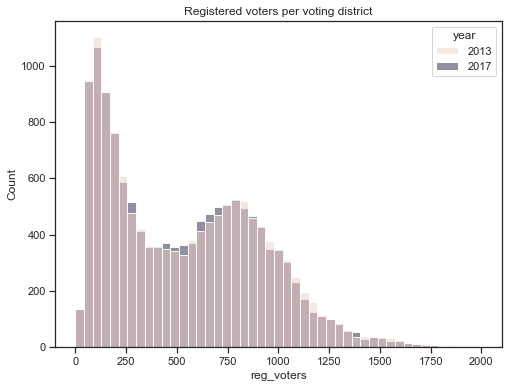

In [13]:
sns.histplot(data=voters_attendance , x='reg_voters', binrange=(0, 2000), hue='year')\
    .set(title='Registered voters per voting district')

Voter attendance seems to have a correlation with number of voters in the voting district. It will be worth exploring in the model.

Text(0.5, 0.98, 'Attendance and district size')

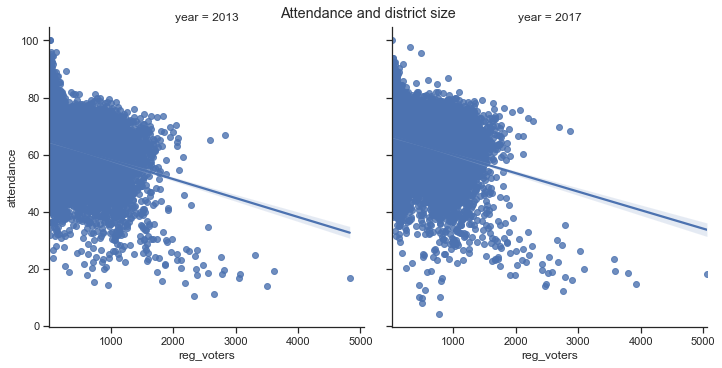

In [14]:
sns.lmplot(data=voters_attendance, x='reg_voters', y='attendance', col='year').fig.suptitle('Attendance and district size')

Attendance follows a normal distribution, as might be expected. It is notable that it increased in 2017.

[Text(0.5, 1.0, 'Voter attendance in districts')]

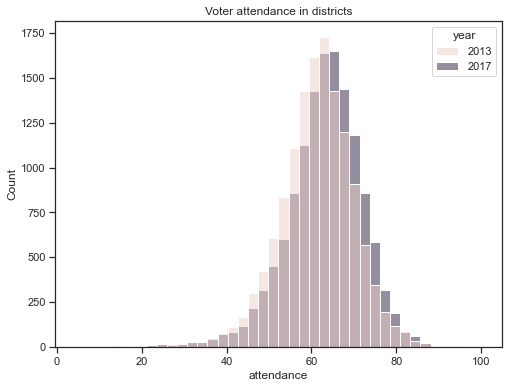

In [15]:
sns.histplot(voters_attendance, x='attendance', bins=40, hue='year').set(title='Voter attendance in districts')

In [16]:
df[['attendance_13', 'attendance_17']].describe()

,attendance_13,attendance_17
count,13540.000000,13540.000000
mean,61.091597,62.949046
std,9.034477,9.254552
min,10.636480,4.409857
25%,56.055706,58.032756
50%,61.617031,63.636364
75%,66.666667,68.876623
max,100.000000,100.000000


### Demographic data
The demographic data provided in the dataset are the following:
- Total population in the district
- Total men
- Total women
- Count of divorced
- Count of children up to 14 yrs
- Count of people 65+ yrs
- Gipsy population
- Count of people with university education (highest)
- Count of people with education level 5
- Count of people with education level 4
- Count of people with education level 3
- Count of people with education level 2
- Count of people with at most grammar school (lowest)
- Count of Roman Catholics
- Count of employed people - unretired
- Count of employed people - retired but working
- Count of unemployed people
- Count of retired not working people


#### Education data

This data shows the maximum reached level of education for the population. The levels are not cummulative

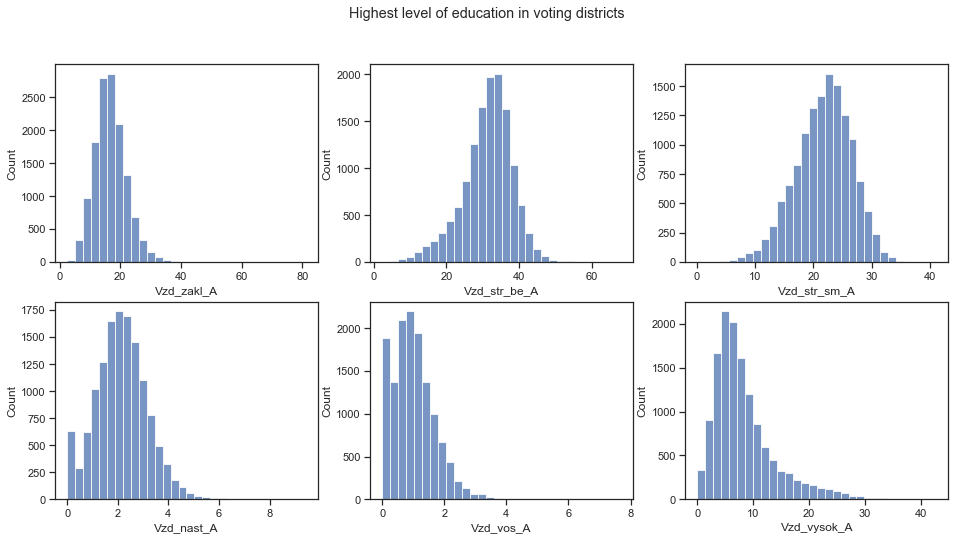

In [17]:
fig, ax = plt.subplots(2,3)
fig.set_size_inches(16, 8)
fig.suptitle('Highest level of education in voting districts')
for i, lvl in enumerate(educ_levels_cols):
    sns.histplot(data=df, x=lvl, bins=30, ax=ax[i//3, i%3])

##### Correlation between voter attendance and district education

[Text(0.5, 1.0, 'Correlation of attendance with education')]

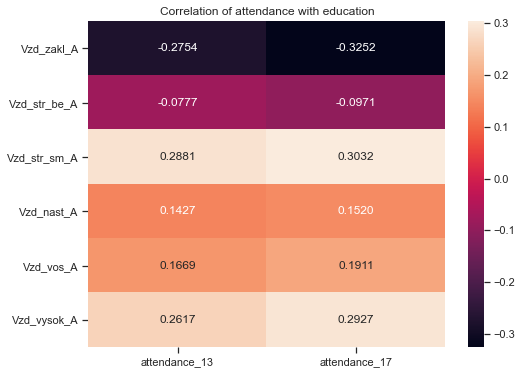

In [18]:
utils.make_heatmap(df, attendances, educ_levels_cols, 'Correlation of attendance with education')

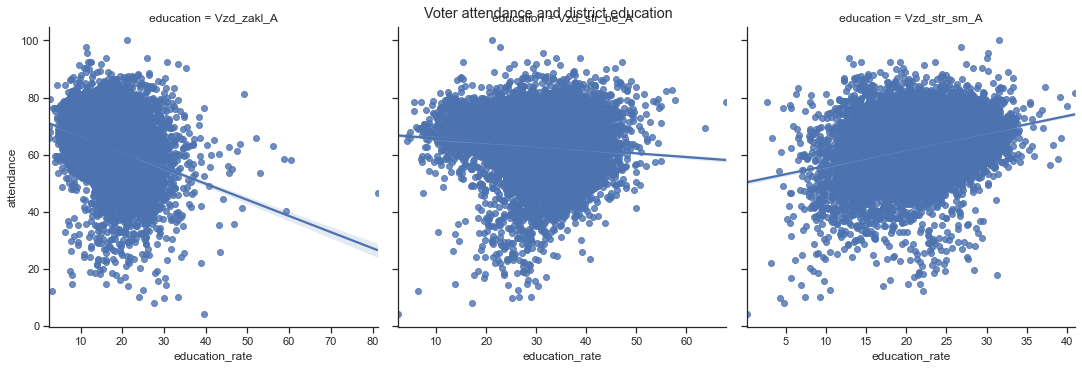

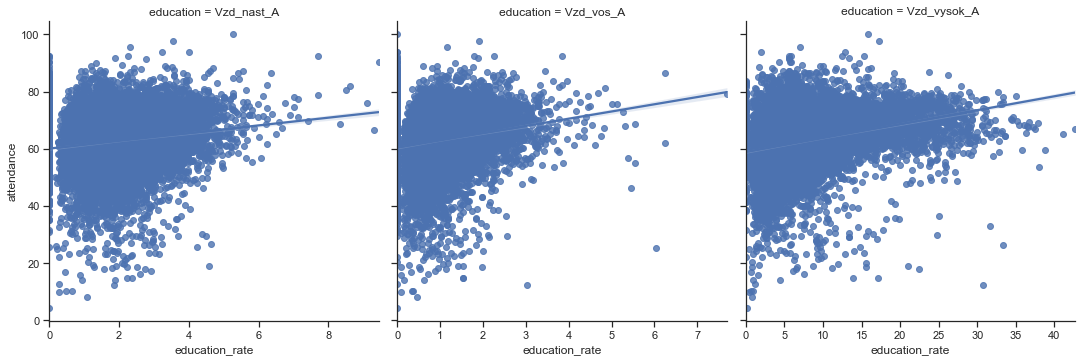

In [19]:
temp_df = utils.init_row_df(['attendance', 'education_rate'], 'education')
for lvl in educ_levels_cols[0:3]:
    temp_df = utils.add_to_row_df(temp_df, df[['attendance_17', lvl]], lvl)
sns.lmplot(data=temp_df, x='education_rate', y='attendance', col='education', sharex=False).fig.suptitle('Voter attendance and district education')

temp_df = utils.init_row_df(['attendance', 'education_rate'], 'education')
for lvl in educ_levels_cols[3:6]:
    temp_df = utils.add_to_row_df(temp_df, df[['attendance_17', lvl]], lvl)
sns.lmplot(data=temp_df, x='education_rate', y='attendance', col='education', sharex=False)

There definitely is a relationship between the education level of a voting district and the voter attendance and it is worthwile to investigate it. From an initial observation, it appears that districts in which a higher percentage of the population have a lower education level tend to vote less and districts with a more eduated population vote more.

### Emplyoment data

[Text(0.5, 1.0, 'Correlation of attendance with employment')]

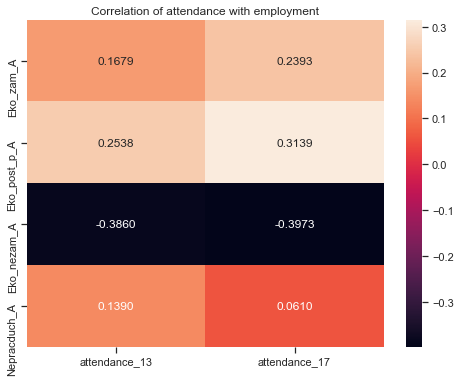

In [20]:
utils.make_heatmap(df, attendances, empl_states_cols, 'Correlation of attendance with employment')

Text(0.5, 0.98, 'Voter attendance and district employment')

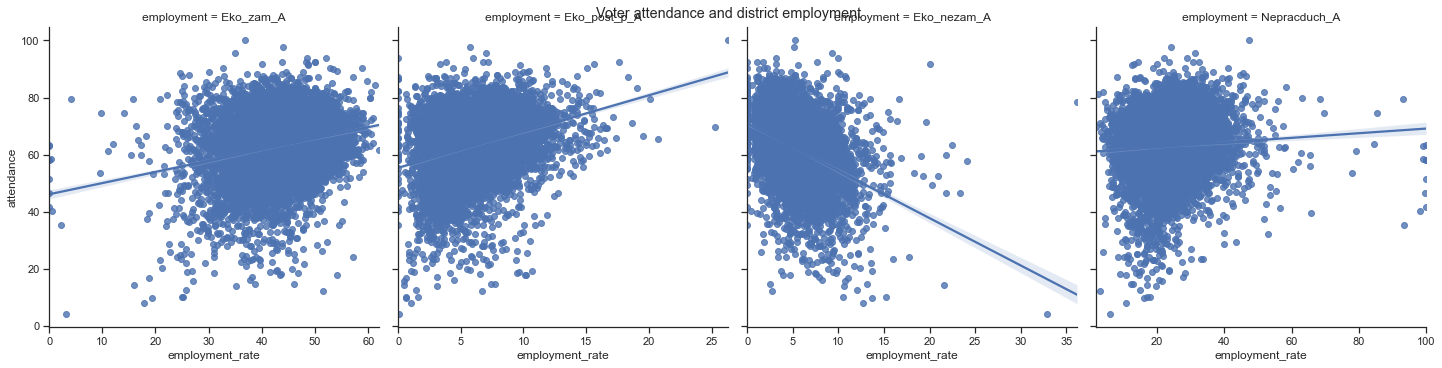

In [21]:
temp_df = utils.make_row_df(df, ['attendance', 'employment_rate'], empl_states_cols, 'attendance_17', 'employment')
sns.lmplot(data=temp_df, x='employment_rate', y='attendance', col='employment', sharex=False).fig.suptitle('Voter attendance and district employment')

Whilist retirement is not correlated to voter attendance, the employment metric is worth investigating further.

### Age data
The age data available are people under 14 and over 65

Text(0.5, 0.98, 'Voter attendance and district age')

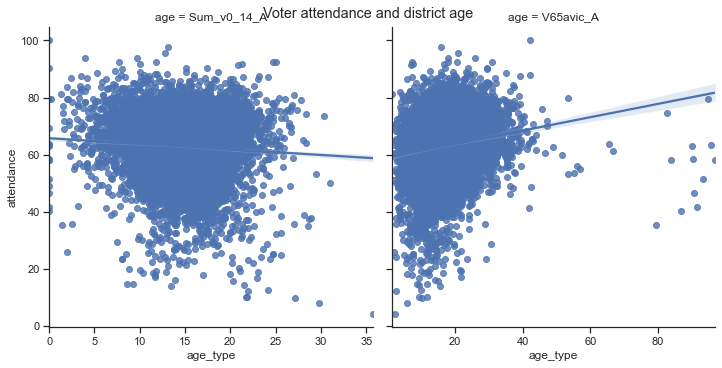

In [22]:
temp_df = utils.make_row_df(df, ['attendance', 'age_type'], age_cols, 'attendance_17', 'age')
sns.lmplot(data=temp_df, x='age_type', y='attendance', col='age', sharex=False).fig.suptitle('Voter attendance and district age')

There is a slight impact on attendance for the elderly population, but none at all for a young population. That makes sense, given that they cannot vote.

### Miscelaneous data
The remaining data columns are
- Population share - men
- Population share - women
- Gipsy population
- Population share of Roman Catholics
- Population share of divorced


[Text(0.5, 1.0, 'Correlation of attendance with remaining demographic data')]

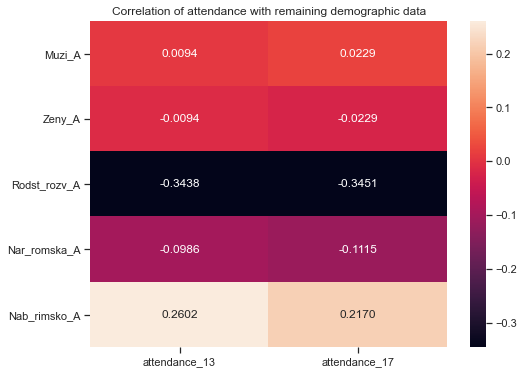

In [23]:
utils.make_heatmap(df, attendances, misc_cols, 'Correlation of attendance with remaining demographic data')

Gender data isn't useful to estimating voter turnout.  Divorce rates and catholics might be worth exploring.

[Text(0.5, 1.0, 'Correlation of attendances and demographic data')]

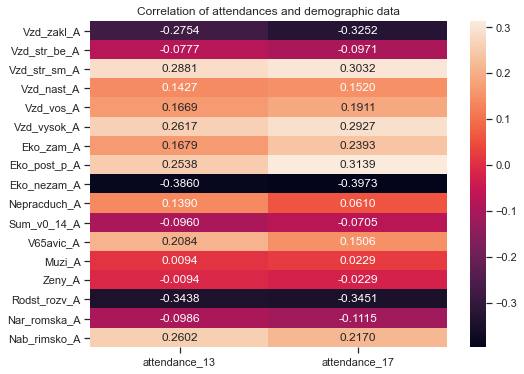

In [24]:
utils.make_heatmap(df, attendances, demographics_cols, 'Correlation of attendances and demographic data')

[Text(0.5, 1.0, 'Correlation of attendances and 2017 party results')]

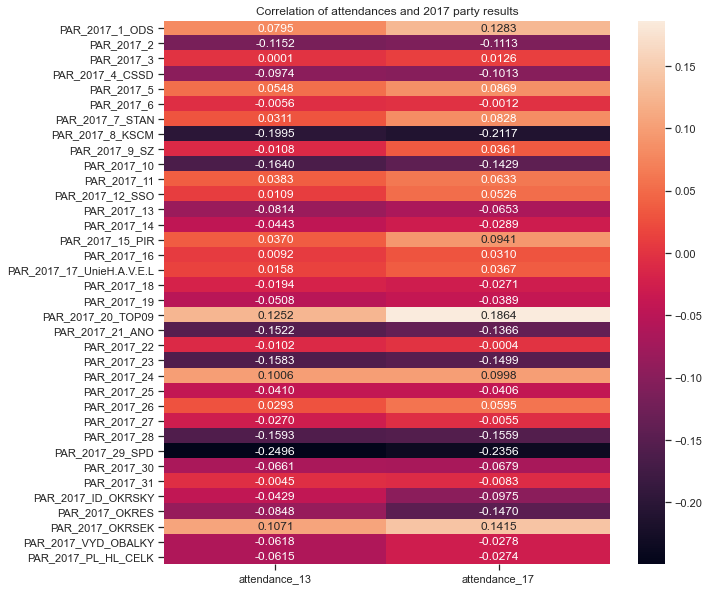

In [48]:
parties_cols_17 = [col for col in df.columns if col.startswith('PAR_2017_')]

plt.figure(figsize=(10,10))
utils.make_heatmap(df, attendances, parties_cols_17, 'Correlation of attendances and 2017 party results')

### Analysis
#### Test/train split
It makes sense that the test data will only from the 2017 election. The model will be trained on the 2013 election and the selected features of the dataset and the 2017 election will be used for cross-validation. Given the previous exploration, the features that will be tried are the district population, demographic data and 2017 elections data.

In [36]:
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet
targets = ['attendance_17']
model_type = Ridge

In [37]:
features = ['attendance_13']
features_to_try = ['reg_voters_13', 'reg_voters_17'] + demographics_cols
final_score_dem, final_features_dem = utils.optimise_features(df, model_type, targets, ['attendance_13'], features_to_try, debug_print=False)

Initial score with only 2013 attendance: 0.70879023777997
Obtained score 0.7385066874814369


With the maximised score of 0.7385 from demographic data, let's try adding the party voting data as well. They had a much smaller correlation with attendance, but given the higher amount of them, they might improve the model further.


In [38]:
features_to_try = ['reg_voters_13', 'reg_voters_17'] + demographics_cols + parties_cols_17
final_score_17, final_features_17 = utils.optimise_features(df, model_type, targets, ['attendance_13'], features_to_try, debug_print=False)

Initial score with only 2013 attendance: 0.70879023777997
Obtained score 0.778917845452176


The 2017 elections data seems to provide quite a substantial improvement.

In [39]:
parties_cols_13 = [col for col in df.columns if col.startswith('PAR_2013_')]

features_to_try = ['reg_voters_13', 'reg_voters_17'] + demographics_cols + parties_cols_17 + parties_cols_13
final_score_13, final_features_13 = utils.optimise_features(df, model_type, targets, ['attendance_13'], features_to_try, debug_print=False)

Initial score with only 2013 attendance: 0.70879023777997
Obtained score 0.778917845452176


Adding the 2013 elections data provides no improvement to R2.

### Create attendance estimates
With a trained and tested model, create estimates for each region. Let's inspect the estimates for a quick sanity check.

In [40]:
est = df
for name, feat in [('estimate_dem', final_features_dem), ('estimate_17', final_features_17), ('estimate_13', final_features_13)]:
    model = model_type().fit(df[feat], df[targets])
    est[name] = model.predict(df[feat])

est[['estimate_dem', 'estimate_17', 'estimate_13', 'attendance_13', 'attendance_17']].describe()

,estimate_dem,estimate_17,estimate_13,attendance_13,attendance_17
count,13540.000000,13540.000000,13540.000000,13540.000000,13540.000000
mean,62.949046,62.949046,62.949046,61.091597,62.949046
std,8.087409,8.298731,8.552049,9.034477,9.254552
min,6.010982,-30.792633,-30.028887,10.636480,4.409857
25%,58.475006,58.879498,58.661713,56.055706,58.032756
50%,63.606835,63.871834,63.784708,61.617031,63.636364
75%,68.137031,68.208094,68.293118,66.666667,68.876623
max,99.959732,92.466424,138.541877,100.000000,100.000000


A -30% or 138% voter attendance is not possible. This is likely an overfitting problem. the purely demographic prediction appears usable. Let's try to iterate on it with using only select election data. I will reference the prior data exploration.

In [41]:
selected_party_cols_1 = ['PAR_2017_20_TOP09']
selected_party_cols_2 = ['PAR_2017_20_TOP09', 'PAR_2017_8_KSCM']
selected_party_cols_3 = ['PAR_2017_20_TOP09', 'PAR_2017_8_KSCM', 'PAR_2017_29_SPD', 'PAR_2017_1_ODS']

feat_cols = [
    ('estimate_p1', selected_party_cols_1),
    ('estimate_p2', selected_party_cols_2),
    ('estimate_p3', selected_party_cols_3)
]
for name, feat in feat_cols:
    features_to_try = ['reg_voters_13', 'reg_voters_17'] + demographics_cols + feat
    __, final_features = utils.optimise_features(df, model_type, targets, ['attendance_13'], features_to_try, debug_print=False)
    model = model_type().fit(df[final_features], df[targets])
    est[name] = model.predict(df[final_features])

est[['estimate_dem', 'estimate_p1', 'estimate_p2', 'estimate_p3','attendance_13', 'attendance_17']].describe()

Initial score with only 2013 attendance: 0.70879023777997
Obtained score 0.7496715288149243
Initial score with only 2013 attendance: 0.70879023777997
Obtained score 0.7518019592456429
Initial score with only 2013 attendance: 0.70879023777997
Obtained score 0.7655335768026147


,estimate_dem,estimate_p1,estimate_p2,estimate_p3,attendance_13,attendance_17
count,13540.000000,13540.000000,13540.000000,13540.000000,13540.000000,13540.000000
mean,62.949046,62.949046,62.949046,62.949046,61.091597,62.949046
std,8.087409,8.135392,8.146428,8.214493,9.034477,9.254552
min,6.010982,5.798543,6.199486,-7.513812,10.636480,4.409857
25%,58.475006,58.503685,58.546760,58.625694,56.055706,58.032756
50%,63.606835,63.551660,63.609263,63.740927,61.617031,63.636364
75%,68.137031,68.153960,68.166087,68.168182,66.666667,68.876623
max,99.959732,96.285951,95.988887,94.075379,100.000000,100.000000


By using the election results of the party most correlated with 2017 attendance, the score improved somewhat significantly. Adding the most anti-correlated party improved it even further. Adding the second of each already produces unrealistic estimates. Let's continue with `estimate_p2`.

In [43]:
df['estimate'] = est['estimate_p2']
df.to_csv('estimated.csv')

### MapReduce to calculate region and overall mean
The dataframe along with the estimates will be exported to csv to simply simulate a BD database. The Map function will be provided a csv line of the datafrane. It will find the region `R`, attendance `a` and output `(R(a, 1))`, meaning the mean of region `R` is `a`. `Reduce` will then aggregate the means until the final mean is obtained, which should look something like `("Praha" (63, 1000))`. The MapReduce code is included MeanCount.java

This is the output of the MapReduce code.

In [33]:
import re

kraje = {}
with open('mr_output.txt', encoding='utf-8') as file:
    for line in file:
        split_line = re.split("\s\s+", line)
        mean = float(split_line[1].split('_')[0])
        kraje[split_line[0]] =  mean
mdf = pd.DataFrame(kraje.items(), columns=['Kraj', 'Attendance'])
mdf

,Kraj,Attendance
0,Jihomoravský kraj,63.145470
1,Jihočeský kraj,64.265334
2,Karlovarský kraj,55.139673
3,Kraj Vysočina,65.856753
4,Královéhradecký kraj,63.657911
5,Liberecký kraj,60.842009
6,Moravskoslezský kraj,58.332975
7,Olomoucký kraj,61.607783
8,Pardubický kraj,63.514117
9,Plzeňský kraj,62.703933


These values look plausible and can now be used to compare individual voting districts to the average.

<AxesSubplot:xlabel='Attendance', ylabel='Count'>

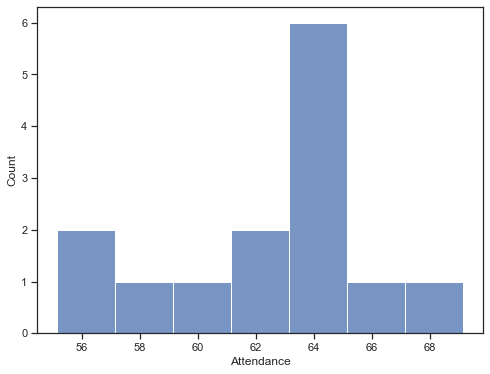

In [34]:
sns.histplot(data=mdf, x='Attendance', binwidth=2)

### Summary
With the regional averages computed, it is now just a simple query to figure out whether a particular town's voter attendance is above/below the region average. The averages are distributed as might be expected with the capital city having the highest voter attendance, and the more fringe regions having a lower attendance.

In [35]:
def is_higher_than_region_avg(df, town_id):
    if df[df['OBEC'] == town_id].shape[0] == 0:
        return None
    region_name = df[df['OBEC'] == town_id]['Kraj_nazev'].head(1).item().strip()
    region_avg = mdf[mdf['Kraj'] == region_name]['Attendance'].item()
    town_avg = df[df['OBEC'] == town_id].groupby('OBEC').agg({'estimate': 'mean'})['estimate'].item()
    return town_avg > region_avg

print(is_higher_than_region_avg(df, 500054))  # Praha 1
print(is_higher_than_region_avg(df, 500119))  # Praha 4

True
False


The model could be further extended by providing updated demographics data. Having access to the trend of education or employment in a town could help better predict the future trend.

Another possible improvement could be trying to utilise a different kind of data, such as geographic. For example villages with a train connection to a big town might have a higher attendance than ones without a train connection. If data of a similar nature would be available for 2017 and the current year, it might provide better insights.